# Preparations

In this exercise we will make use of the ``memory_profiler`` package.

In [1]:
%pip install memory_profiler

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

Complete the code below to implement a random walk class, which allows a user to iterate over the steps in a 1-dimensional random walk. Use the following rule the compute the  step position $x_n$ at timestep $n$:

\begin{align}
x_n = x_{n - 1} + \Delta x,
\end{align}

with $\Delta x$ a sample from a normal distribution $\mathcal{N}(0, 1)$ with mean $0$ and standard deviation $1$ and $x_0 = 0$. To generate a sample from a normal distribution you can use ``random.gauss`` or ``numpy.random.normal``.

## a)

In [2]:
import random
from collections.abc import Iterable, Iterator

class RandomWalkIterator(Iterator):
    """
    Iterator for steps in a random walk.
    """
    def __init__(self, walk):
        self.walk = walk
        self.index = 0

    def __next__(self):
        if self.index < self.walk.n_steps:
            item = self.walk.steps[self.index]
            self.index += 1
            return item
        raise StopIteration()

    def __iter__(self):
        return self

class RandomWalkIterable(Iterable):
    """
    A 1-dimensional random walk with unit step size.
    """
    def __init__(self, n_steps = 1000):
        """
        Args:
            n_steps: The number of random walk steps to perform.
        """
        pos = 0.0
        self.n_steps = n_steps
        self.steps = []
        for i in range(n_steps):
            pos += random.gauss(0, 1)
            self.steps.append(pos)

    def __iter__(self):
        return RandomWalkIterator(self)
       

Then, execute the code below to profile the memory consumption of calculating the standard deviation of the random walk. Discuss the form of the memory profile.

In [4]:
def calculate_std(random_walk):
    """
    Calculate standard deviation of a random walk.

    Args:
        random_walk(``Iterable``): An iterable over the steps of
             a random walk.
    """
    n = 0
    step_squared_sum = 0.0
    step_sum = 0.0
    for step in random_walk:
        step_sum += step
        step_squared_sum += step * step
        n += 1
    return (step_squared_sum - step_sum) / n


In [7]:
from memory_profiler import memory_usage

# Helper function to execute calculation.
def calculate_random_walk_iterator():
    return calculate_std(RandomWalkIterable(10_000_000))

# memory_usage returns amount of used memory per 0.1 s.
memory_iterator = memory_usage(calculate_random_walk_iterator)
# Subtract amount of memory occupied before call.
memory_iterator = np.array(memory_iterator)
memory_iterator -= memory_iterator[0]

Text(0, 0.5, 'Memory used [MB]')

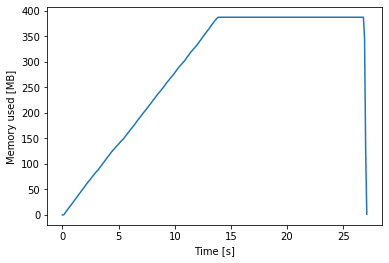

In [8]:
time_iterator = 0.1 * np.arange(len(memory_iterator))
plt.plot(time_iterator, memory_iterator)
plt.xlabel("Time [s]")
plt.ylabel("Memory used [MB]")

## b)

Complete the code below to implement a generator version of the random walk code. Remember that you can use ``yield`` to simplify your code.

In [10]:
class RandomWalkGenerator:
    """
    A 1-dimensional random walk with unit step size.
    """
    def __init__(self, n_steps = 1000):
        self.pos = 0.0
        self.step = 0
        self.n_steps = n_steps

    def __iter__(self):
        for i in range(self.n_steps - 1):
            current_pos = self.pos
            self.pos += random.gauss(0, 1)
            yield current_pos
        return self.pos

Then, use the code below to compar the memory profiles of the two implementations. How do they differ?

In [11]:
def calculate_random_walk_generator():
    return calculate_std(RandomWalkGenerator(10_000_000))

In [ ]:
memory_generator = memory_usage(calculate_random_walk_generator)
# Subtract amount of memory occupied before call.
memory_generator = np.array(memory_generator)
memory_generator -= memory_generator[0]

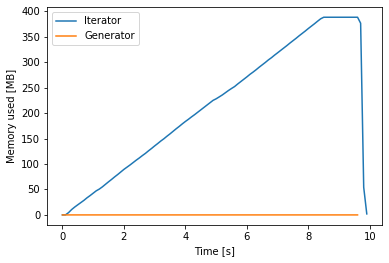

In [10]:
time_generator = 0.1 * np.arange(len(memory_generator))
plt.plot(time_iterator, memory_iterator, label="Iterator")
plt.plot(time_generator, memory_generator, label="Generator")
plt.xlabel("Time [s]")
plt.ylabel("Memory used [MB]")
plt.legend()
plt.savefig("figures/memory_used.pdf")

# Exercise 2

Complete the two functions to filter positive steps from the random walk. For the first one use a ``for`` loop and
for the second a list comprehension.

In [11]:
def filter_positive_loop(random_walk):
    positive_steps = []
    for step in random_walk:
        positive_steps.append(step)
    return positive_steps

In [12]:
def filter_positive_comprehension(random_walk):
    return [r for r in random_walk if r > 0.0]


In [13]:
random_walk = RandomWalkIterable(1_000_000)

The code below measures the execution time of the two methods. Each method is invoked in two different ways. Discuss the result.

In [14]:
%timeit filter_positive_loop(random_walk)

89.7 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit filter_positive_loop(random_walk.steps)

49.9 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit filter_positive_comprehension(random_walk)

66.6 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit filter_positive_comprehension(random_walk.steps)

35.2 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Exercise 3

Write a decorator ``@maximum_memory`` that prints out the maximum amount of memory required during the execution of a function.

**Note:** You can forward arugments to the ``memory_usage`` function by passing a tuple ``(f, args, kwargs)``
    containing the function ``f`` to call, the list of positional arguments ``args`` and the dictionary
    of keyword args ``kwargs``.

In [18]:
def maximum_memory(f):
    def wrapper(*args, **kwargs):
        memory = memory_usage((f, args, kwargs))
        memory = np.array(memory)
        memory -= memory[0]
        print(f"Maximum memory usage: {max(memory)} MB")
    return wrapper

In [19]:
@maximum_memory
def calculate_random_walk_decorated(n_steps):
    calculate_std(RandomWalkIterable(n_steps))

In [20]:
calculate_random_walk_decorated(10000000)

Maximum memory usage: 389.203125 MB


# Exercise 4

Apply the flyweight pattern to reduce the memory footprint of the ``RandomWalkIterableClass``.

In [21]:
import random
from collections.abc import Iterable, Iterator

class RandomWalkIterator(Iterator):
    """
    Iterator for steps in a random walk.
    """
    def __init__(self, walk):
        self.walk = walk
        self.index = 0

    def __next__(self):
        if self.index < self.walk.n_steps:
            item = self.walk.steps[self.index]
            self.index += 1
            return item
        raise StopIteration()

    def __iter__(self):
        return self

class RandomWalkIterable(Iterable):
    """
    A 1-dimensional random walk with unit step size.
    """
    _steps = []
    _n_steps = 0
    def __new__(cls, n_steps):
        if (n_steps > cls._n_steps):
            cls._steps = cls._calculate_random_walk(n_steps)
            cls._n_steps = n_steps
        random_walk = super().__new__(cls)
        random_walk.n_steps = n_steps
        random_walk.steps = cls._steps
        return random_walk
            
    @staticmethod
    def _calculate_random_walk(n_steps):
        pos = 0.0
        steps = []
        for i in range(n_steps):
            steps.append(pos)
            pos += random.gauss(0, 1)
        return steps
        
    
    def __init__(self, n_steps = 1000):
        pass
            
        
    def __iter__(self):
        for i in range(self.n_steps):
            yield self.steps[i]

In [22]:
def calculate_random_walk_flyweight():
    return calculate_std(RandomWalkIterable(10_000_000))

In [23]:
memory_flyweight_1 = np.array(memory_usage(calculate_random_walk_flyweight))
memory_flyweight_1 -= memory_flyweight_1[0]
memory_flyweight_2 = np.array(memory_usage(calculate_random_walk_flyweight))
memory_flyweight_2 -= memory_flyweight_2[0]

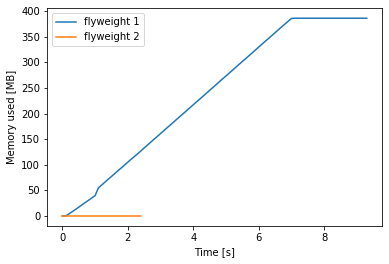

In [24]:
time_flyweight_1 = 0.1 * np.arange(len(memory_flyweight_1))
time_flyweight_2 = 0.1 * np.arange(len(memory_flyweight_2))
plt.plot(time_flyweight_1, memory_flyweight_1, label="flyweight 1")
plt.plot(time_flyweight_2, memory_flyweight_2, label="flyweight 2")
plt.xlabel("Time [s]")
plt.ylabel("Memory used [MB]")
plt.legend()
plt.savefig("figures/memory_used_flyweight.pdf")